# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.641093575104788 -2.6753417191638933
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [24]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=tf.ones_like(Qs_logits)))
                                                                    #labels=tf.nn.sigmoid(1+0.99(Qs_logits))))
    g_lossP = tf.reduce_mean(neg_log_prob_actions * targetQs)
    g_loss = g_lossQ + g_lossP

    return actions_logits, Qs_logits, g_loss, d_loss, g_lossQ, g_lossP

In [25]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [26]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.g_lossP = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [27]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [28]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [29]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [30]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [31]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(1111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/200 # success is 200 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_lossQ, g_lossP, g_loss, d_loss, _, _ = sess.run([model.g_lossQ, model.g_lossP, 
                                                           model.g_loss, model.d_loss, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'glossQ:{:.4f}'.format(g_lossQ),
              'glossP:{:.4f}'.format(g_lossP),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 200:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:8.0000 glossQ:0.7461 glossP:-0.0638 gloss:0.6823 dloss:0.6475
Episode:1 meanR:54.5000 glossQ:0.7228 glossP:-0.0391 gloss:0.6837 dloss:0.6942
Episode:2 meanR:50.3333 glossQ:0.7410 glossP:-0.0630 gloss:0.6780 dloss:0.6683
Episode:3 meanR:53.0000 glossQ:0.7491 glossP:-0.0741 gloss:0.6750 dloss:0.6738
Episode:4 meanR:59.6000 glossQ:0.7603 glossP:-0.0882 gloss:0.6721 dloss:0.6865
Episode:5 meanR:61.1667 glossQ:0.7872 glossP:-0.1220 gloss:0.6652 dloss:0.6701
Episode:6 meanR:55.2857 glossQ:0.7600 glossP:-0.0884 gloss:0.6716 dloss:0.6436
Episode:7 meanR:49.8750 glossQ:0.7691 glossP:-0.0997 gloss:0.6693 dloss:0.6316
Episode:8 meanR:45.5556 glossQ:0.7920 glossP:-0.1283 gloss:0.6637 dloss:0.6139
Episode:9 meanR:42.1000 glossQ:0.8236 glossP:-0.1664 gloss:0.6572 dloss:0.5919
Episode:10 meanR:39.0909 glossQ:0.8485 glossP:-0.1906 gloss:0.6579 dloss:0.5726
Episode:11 meanR:36.5000 glossQ:0.8794 glossP:-0.2268 gloss:0.6526 dloss:0.5514
Episode:12 meanR:34.3846 glossQ:0.9290 glossP:-0.28

Episode:109 meanR:22.3700 glossQ:2.1843 glossP:-1.4120 gloss:0.7724 dloss:0.7090
Episode:110 meanR:22.6100 glossQ:2.1768 glossP:-1.4071 gloss:0.7698 dloss:0.4606
Episode:111 meanR:22.9500 glossQ:2.1264 glossP:-1.3638 gloss:0.7626 dloss:0.5478
Episode:112 meanR:23.1000 glossQ:2.1187 glossP:-1.3594 gloss:0.7593 dloss:0.3681
Episode:113 meanR:23.3400 glossQ:2.0916 glossP:-1.3367 gloss:0.7549 dloss:0.4760
Episode:114 meanR:23.8300 glossQ:2.0363 glossP:-1.2939 gloss:0.7424 dloss:0.7097
Episode:115 meanR:23.9900 glossQ:2.0707 glossP:-1.3212 gloss:0.7496 dloss:0.4169
Episode:116 meanR:24.0800 glossQ:2.0619 glossP:-1.3148 gloss:0.7471 dloss:0.3974
Episode:117 meanR:24.1500 glossQ:2.0637 glossP:-1.3161 gloss:0.7476 dloss:0.3594
Episode:118 meanR:24.1800 glossQ:2.0600 glossP:-1.3143 gloss:0.7457 dloss:0.2921
Episode:119 meanR:24.1600 glossQ:2.1682 glossP:-1.3975 gloss:0.7707 dloss:0.2573
Episode:120 meanR:24.1500 glossQ:2.1954 glossP:-1.4193 gloss:0.7761 dloss:0.2778
Episode:121 meanR:24.1200 gl

Episode:211 meanR:46.8000 glossQ:1.0145 glossP:-0.3879 gloss:0.6266 dloss:1.8570
Episode:212 meanR:51.5600 glossQ:0.9511 glossP:-0.3180 gloss:0.6331 dloss:1.6416
Episode:213 meanR:56.2100 glossQ:0.8919 glossP:-0.2490 gloss:0.6429 dloss:1.4325
Episode:214 meanR:56.0800 glossQ:1.0384 glossP:-0.4135 gloss:0.6249 dloss:0.5789
Episode:215 meanR:56.1400 glossQ:1.0242 glossP:-0.3976 gloss:0.6266 dloss:0.5471
Episode:216 meanR:56.8500 glossQ:0.8914 glossP:-0.2451 gloss:0.6463 dloss:0.7102
Episode:217 meanR:56.9800 glossQ:0.9425 glossP:-0.3080 gloss:0.6346 dloss:0.5755
Episode:218 meanR:57.1600 glossQ:0.9556 glossP:-0.3222 gloss:0.6334 dloss:0.5667
Episode:219 meanR:57.2900 glossQ:0.8947 glossP:-0.2530 gloss:0.6417 dloss:0.5750
Episode:220 meanR:57.4000 glossQ:0.9079 glossP:-0.2681 gloss:0.6398 dloss:0.5689
Episode:221 meanR:57.5300 glossQ:0.9745 glossP:-0.3420 gloss:0.6324 dloss:0.5361
Episode:222 meanR:57.5900 glossQ:0.9124 glossP:-0.2722 gloss:0.6402 dloss:0.5477
Episode:223 meanR:57.6500 gl

Episode:315 meanR:38.5800 glossQ:1.6118 glossP:-0.9294 gloss:0.6824 dloss:0.3124
Episode:316 meanR:37.6800 glossQ:1.6356 glossP:-0.9510 gloss:0.6847 dloss:0.3108
Episode:317 meanR:37.4600 glossQ:1.5470 glossP:-0.8945 gloss:0.6525 dloss:0.3426
Episode:318 meanR:37.2400 glossQ:1.5444 glossP:-0.8926 gloss:0.6518 dloss:0.3297
Episode:319 meanR:37.0800 glossQ:2.4261 glossP:-1.5235 gloss:0.9026 dloss:0.2690
Episode:320 meanR:36.9700 glossQ:1.4199 glossP:-0.7846 gloss:0.6353 dloss:0.3693
Episode:321 meanR:36.8600 glossQ:1.5082 glossP:-0.8620 gloss:0.6462 dloss:0.3400
Episode:322 meanR:36.8300 glossQ:1.5418 glossP:-0.8913 gloss:0.6505 dloss:0.3343
Episode:323 meanR:36.8000 glossQ:1.5844 glossP:-0.9294 gloss:0.6550 dloss:0.3456
Episode:324 meanR:36.7900 glossQ:1.6802 glossP:-1.0093 gloss:0.6710 dloss:0.3347
Episode:325 meanR:36.7700 glossQ:1.7099 glossP:-1.0333 gloss:0.6767 dloss:0.3393
Episode:326 meanR:36.6900 glossQ:1.9236 glossP:-1.2061 gloss:0.7175 dloss:0.2805
Episode:327 meanR:36.6600 gl

Episode:420 meanR:22.0500 glossQ:2.0100 glossP:-1.2822 gloss:0.7278 dloss:0.3403
Episode:421 meanR:22.1900 glossQ:2.0481 glossP:-1.3112 gloss:0.7369 dloss:0.4069
Episode:422 meanR:22.3400 glossQ:2.0339 glossP:-1.3023 gloss:0.7316 dloss:0.4133
Episode:423 meanR:22.5100 glossQ:1.9744 glossP:-1.2576 gloss:0.7168 dloss:0.4545
Episode:424 meanR:22.7600 glossQ:1.8944 glossP:-1.1933 gloss:0.7011 dloss:0.5219
Episode:425 meanR:22.8700 glossQ:1.8264 glossP:-1.1379 gloss:0.6884 dloss:0.4098
Episode:426 meanR:23.6900 glossQ:1.8636 glossP:-1.1705 gloss:0.6932 dloss:0.9671
Episode:427 meanR:23.9800 glossQ:1.8946 glossP:-1.1887 gloss:0.7059 dloss:0.5197
Episode:428 meanR:24.2800 glossQ:1.8605 glossP:-1.1605 gloss:0.7000 dloss:0.5261
Episode:429 meanR:24.7500 glossQ:1.8037 glossP:-1.1148 gloss:0.6890 dloss:0.6755
Episode:430 meanR:25.1300 glossQ:1.6678 glossP:-1.0063 gloss:0.6616 dloss:0.5849
Episode:431 meanR:25.6400 glossQ:1.8351 glossP:-1.1412 gloss:0.6939 dloss:0.7049
Episode:432 meanR:26.1900 gl

Episode:523 meanR:32.2800 glossQ:2.0046 glossP:-1.2678 gloss:0.7368 dloss:0.3265
Episode:524 meanR:32.6500 glossQ:1.3820 glossP:-0.7495 gloss:0.6325 dloss:0.7209
Episode:525 meanR:33.0900 glossQ:1.3387 glossP:-0.7130 gloss:0.6257 dloss:0.6787
Episode:526 meanR:32.4300 glossQ:1.3854 glossP:-0.7575 gloss:0.6279 dloss:0.4429
Episode:527 meanR:32.4100 glossQ:1.3406 glossP:-0.7157 gloss:0.6249 dloss:0.5019
Episode:528 meanR:32.2500 glossQ:1.3223 glossP:-0.6987 gloss:0.6236 dloss:0.4378
Episode:529 meanR:31.8700 glossQ:1.3684 glossP:-0.7415 gloss:0.6269 dloss:0.4135
Episode:530 meanR:31.6200 glossQ:1.3325 glossP:-0.7077 gloss:0.6249 dloss:0.4417
Episode:531 meanR:31.1900 glossQ:1.4052 glossP:-0.7752 gloss:0.6300 dloss:0.3960
Episode:532 meanR:30.6800 glossQ:1.4628 glossP:-0.8275 gloss:0.6353 dloss:0.3678
Episode:533 meanR:30.2200 glossQ:1.4514 glossP:-0.8164 gloss:0.6350 dloss:0.3590
Episode:534 meanR:29.8600 glossQ:1.5144 glossP:-0.8724 gloss:0.6419 dloss:0.3217
Episode:535 meanR:29.4000 gl

Episode:627 meanR:29.4500 glossQ:1.7536 glossP:-1.0760 gloss:0.6777 dloss:0.4380
Episode:628 meanR:29.4700 glossQ:1.8049 glossP:-1.1189 gloss:0.6860 dloss:0.4046
Episode:629 meanR:29.5400 glossQ:1.7473 glossP:-1.0710 gloss:0.6764 dloss:0.4222
Episode:630 meanR:29.5600 glossQ:1.7245 glossP:-1.0525 gloss:0.6720 dloss:0.4146
Episode:631 meanR:29.6100 glossQ:1.7809 glossP:-1.1001 gloss:0.6808 dloss:0.3883
Episode:632 meanR:29.6800 glossQ:1.8634 glossP:-1.1678 gloss:0.6956 dloss:0.3778
Episode:633 meanR:29.6800 glossQ:2.0090 glossP:-1.2866 gloss:0.7224 dloss:0.2897
Episode:634 meanR:29.7400 glossQ:1.9970 glossP:-1.2764 gloss:0.7206 dloss:0.3100
Episode:635 meanR:29.8500 glossQ:1.8864 glossP:-1.1844 gloss:0.7020 dloss:0.3714
Episode:636 meanR:29.8500 glossQ:2.5807 glossP:-1.7130 gloss:0.8677 dloss:0.2782
Episode:637 meanR:29.9300 glossQ:2.1053 glossP:-1.3597 gloss:0.7456 dloss:0.3083
Episode:638 meanR:29.9900 glossQ:2.0710 glossP:-1.3362 gloss:0.7348 dloss:0.3246
Episode:639 meanR:30.2200 gl

Episode:730 meanR:42.6000 glossQ:1.7162 glossP:-1.0453 gloss:0.6709 dloss:0.4172
Episode:731 meanR:42.7900 glossQ:1.5446 glossP:-0.9003 gloss:0.6444 dloss:0.5304
Episode:732 meanR:43.1300 glossQ:1.6546 glossP:-0.9834 gloss:0.6712 dloss:0.6460
Episode:733 meanR:43.0700 glossQ:2.7040 glossP:-1.7944 gloss:0.9096 dloss:0.2289
Episode:734 meanR:43.3000 glossQ:1.6880 glossP:-1.0196 gloss:0.6684 dloss:0.5103
Episode:735 meanR:43.5600 glossQ:1.5821 glossP:-0.9302 gloss:0.6519 dloss:0.5676
Episode:736 meanR:43.7700 glossQ:1.6612 glossP:-0.9992 gloss:0.6620 dloss:0.4704
Episode:737 meanR:44.1200 glossQ:1.6552 glossP:-0.9970 gloss:0.6582 dloss:0.5888
Episode:738 meanR:45.0900 glossQ:1.4403 glossP:-0.7924 gloss:0.6479 dloss:0.9581
Episode:739 meanR:45.4300 glossQ:1.6218 glossP:-0.9662 gloss:0.6556 dloss:0.7070
Episode:740 meanR:46.0300 glossQ:1.4931 glossP:-0.8492 gloss:0.6439 dloss:0.8783
Episode:741 meanR:44.9400 glossQ:1.5524 glossP:-0.9065 gloss:0.6459 dloss:0.6287
Episode:742 meanR:43.5500 gl

Episode:832 meanR:48.9100 glossQ:1.0643 glossP:-0.4360 gloss:0.6283 dloss:0.6636
Episode:833 meanR:49.8300 glossQ:1.0175 glossP:-0.3864 gloss:0.6311 dloss:0.7407
Episode:834 meanR:49.9600 glossQ:1.0870 glossP:-0.4573 gloss:0.6297 dloss:0.6005
Episode:835 meanR:49.9600 glossQ:1.0703 glossP:-0.4386 gloss:0.6317 dloss:0.5911
Episode:836 meanR:50.5300 glossQ:1.0139 glossP:-0.3809 gloss:0.6329 dloss:0.7163
Episode:837 meanR:51.0100 glossQ:0.9745 glossP:-0.3391 gloss:0.6355 dloss:0.7293
Episode:838 meanR:50.8000 glossQ:0.9856 glossP:-0.3512 gloss:0.6343 dloss:0.7188
Episode:839 meanR:50.6900 glossQ:1.0405 glossP:-0.4090 gloss:0.6315 dloss:0.6204
Episode:840 meanR:50.2700 glossQ:1.0281 glossP:-0.3977 gloss:0.6304 dloss:0.6198
Episode:841 meanR:50.6900 glossQ:0.9789 glossP:-0.3450 gloss:0.6338 dloss:0.7317
Episode:842 meanR:51.1000 glossQ:1.0196 glossP:-0.3888 gloss:0.6308 dloss:0.6960
Episode:843 meanR:51.8800 glossQ:0.9860 glossP:-0.3522 gloss:0.6338 dloss:0.7415
Episode:844 meanR:52.6800 gl

Episode:934 meanR:109.6700 glossQ:0.2589 glossP:0.9025 gloss:1.1614 dloss:-0.2047
Episode:935 meanR:110.5700 glossQ:0.2497 glossP:0.9081 gloss:1.1578 dloss:0.6511
Episode:936 meanR:110.8100 glossQ:0.2341 glossP:0.9500 gloss:1.1840 dloss:0.8125
Episode:937 meanR:110.8400 glossQ:0.2153 glossP:1.0109 gloss:1.2263 dloss:0.9267
Episode:938 meanR:110.6700 glossQ:0.1645 glossP:1.2529 gloss:1.4174 dloss:1.2733
Episode:939 meanR:110.5300 glossQ:0.2128 glossP:1.0079 gloss:1.2206 dloss:1.3531
Episode:940 meanR:110.4200 glossQ:0.2147 glossP:1.0103 gloss:1.2251 dloss:1.3396
Episode:941 meanR:109.7100 glossQ:0.2605 glossP:0.8664 gloss:1.1269 dloss:1.3320
Episode:942 meanR:109.0700 glossQ:0.3112 glossP:0.7166 gloss:1.0277 dloss:1.2447
Episode:943 meanR:108.2600 glossQ:0.3275 glossP:0.6878 gloss:1.0153 dloss:1.2166
Episode:944 meanR:107.3300 glossQ:0.5199 glossP:0.3135 gloss:0.8334 dloss:0.9559
Episode:945 meanR:106.5000 glossQ:0.7925 glossP:-0.0313 gloss:0.7612 dloss:0.7626
Episode:946 meanR:105.4400

Episode:1039 meanR:42.2100 glossQ:0.7209 glossP:-0.0348 gloss:0.6861 dloss:0.6745
Episode:1040 meanR:42.0100 glossQ:0.7453 glossP:-0.0651 gloss:0.6802 dloss:0.6579
Episode:1041 meanR:41.9400 glossQ:0.7724 glossP:-0.0971 gloss:0.6753 dloss:0.6382
Episode:1042 meanR:41.9800 glossQ:0.7978 glossP:-0.1280 gloss:0.6698 dloss:0.6245
Episode:1043 meanR:41.9300 glossQ:0.8385 glossP:-0.1735 gloss:0.6650 dloss:0.5926
Episode:1044 meanR:42.0300 glossQ:0.8767 glossP:-0.2169 gloss:0.6598 dloss:0.5778
Episode:1045 meanR:42.0800 glossQ:0.9327 glossP:-0.2768 gloss:0.6559 dloss:0.5380
Episode:1046 meanR:42.1900 glossQ:0.9862 glossP:-0.3302 gloss:0.6560 dloss:0.5204
Episode:1047 meanR:42.2400 glossQ:1.0500 glossP:-0.3941 gloss:0.6558 dloss:0.4830
Episode:1048 meanR:42.2700 glossQ:1.1425 glossP:-0.4809 gloss:0.6616 dloss:0.4423
Episode:1049 meanR:42.3400 glossQ:1.2296 glossP:-0.5643 gloss:0.6653 dloss:0.4351
Episode:1050 meanR:42.2900 glossQ:1.3363 glossP:-0.6566 gloss:0.6797 dloss:0.3809
Episode:1051 mea

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

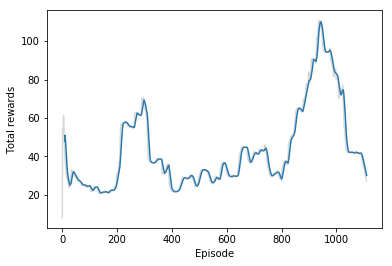

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

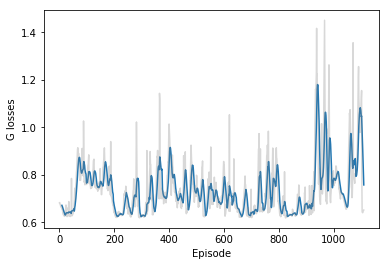

In [34]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

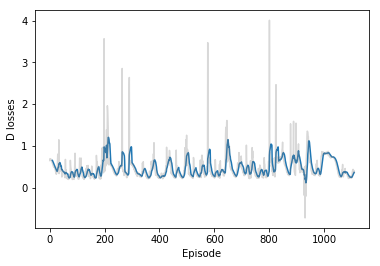

In [35]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.